In [2]:
import json 
import pandas as pd 
import numpy as np 
import os 
import re 
import seaborn as sns 
import matplotlib.pyplot as plt
from omegaconf import OmegaConf 
from glob import glob 
os.chdir('../')

def load_df(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()
    df = pd.DataFrame(list(pd.Series(data).map(eval).values))    
    return df 

def load_log_data(class_name, version, result_dir,method):

    df = pd.DataFrame()
    for i,v in enumerate(version):
        log_dir = os.path.join(result_dir,class_name,method,v,'log.txt')
        
        temp_df = load_df(log_dir)
        temp_df['hue'] = v 
        
        df = pd.concat([df,temp_df])
    
    return df 

def plot_log(data,class_name, metrics:list, figsize:tuple = (10,7)):
    
    fig, axes = plt.subplots(len(metrics),1,figsize=figsize)
    
    for ax, metric in zip(axes, metrics):
        sns.lineplot(
            x = 'epoch',
            y = metric,
            data = data,
            hue = data['hue'],
            ax = ax 
        )
      
    fig.suptitle(class_name)
    plt.show()
    
def read_txt(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()    
    df = pd.DataFrame([eval(d) for d in data]) 
    return df 
pd.options.display.float_format = '{: .3f}'.format 

def temperature_matching(x):
    value = x.split('_')[-1]
    
    if value in ['BASELINE','focalloss']:
        return 0.05 
    elif value in ['T1','T2']:
        return float(value[-1])
    else:
        if len(value) ==1:
            return value 
        else:
            return re.search(r'T_(\d+\.\d+)', x).group(1)
    

# 전체 결과 

## 성능 

In [11]:
def csv_preprocess(df_path):
    df = pd.read_csv(df_path)
    
    if np.sum(df['epoch']) ==0:
        df['epoch'] = df.reset_index()['index']
    
    df = df[df['last']==0].reset_index(drop=True)
    return df

def filter_df(df):
    if df.iloc[-1]['epoch'] == 0:
        return df.iloc[:-1]
    else:
        return df 

def rescale_steps_with_filter(df,step_column='epoch'):
    target_range = (0, 99)
    result = []
    for class_name, group in df.groupby('class_name'):
        original_steps = group[step_column].values
        scaled_steps = np.interp(original_steps, (original_steps.min(), original_steps.max()), target_range)
        group[step_column] = scaled_steps

        # Retain 100 equally spaced points
        filtered_group = filter_df(group)
        result.append(filtered_group)
        
    result = pd.concat(result).reset_index(drop=True)
    return result

def preprocess(df,step_column='epoch'):
    df = rescale_steps_with_filter(df,step_column)

    # img level 
    df['img_level'] = (df['img_level_auroc'] + df['img_level_average_precision'])/2
    df['pix_level'] = (df['pix_level_auroc'] + df['pix_level_average_precision'])/2
    
    return df 

result_path = glob('/Volume/VAD/LifeLongerAD_pilot/results/ReverseDistillation/MVTecAD/*/seed_0/result.csv')
results = {r.split('/')[-3].lstrip('baseline_EMPTY-'):csv_preprocess(r) for r in result_path}

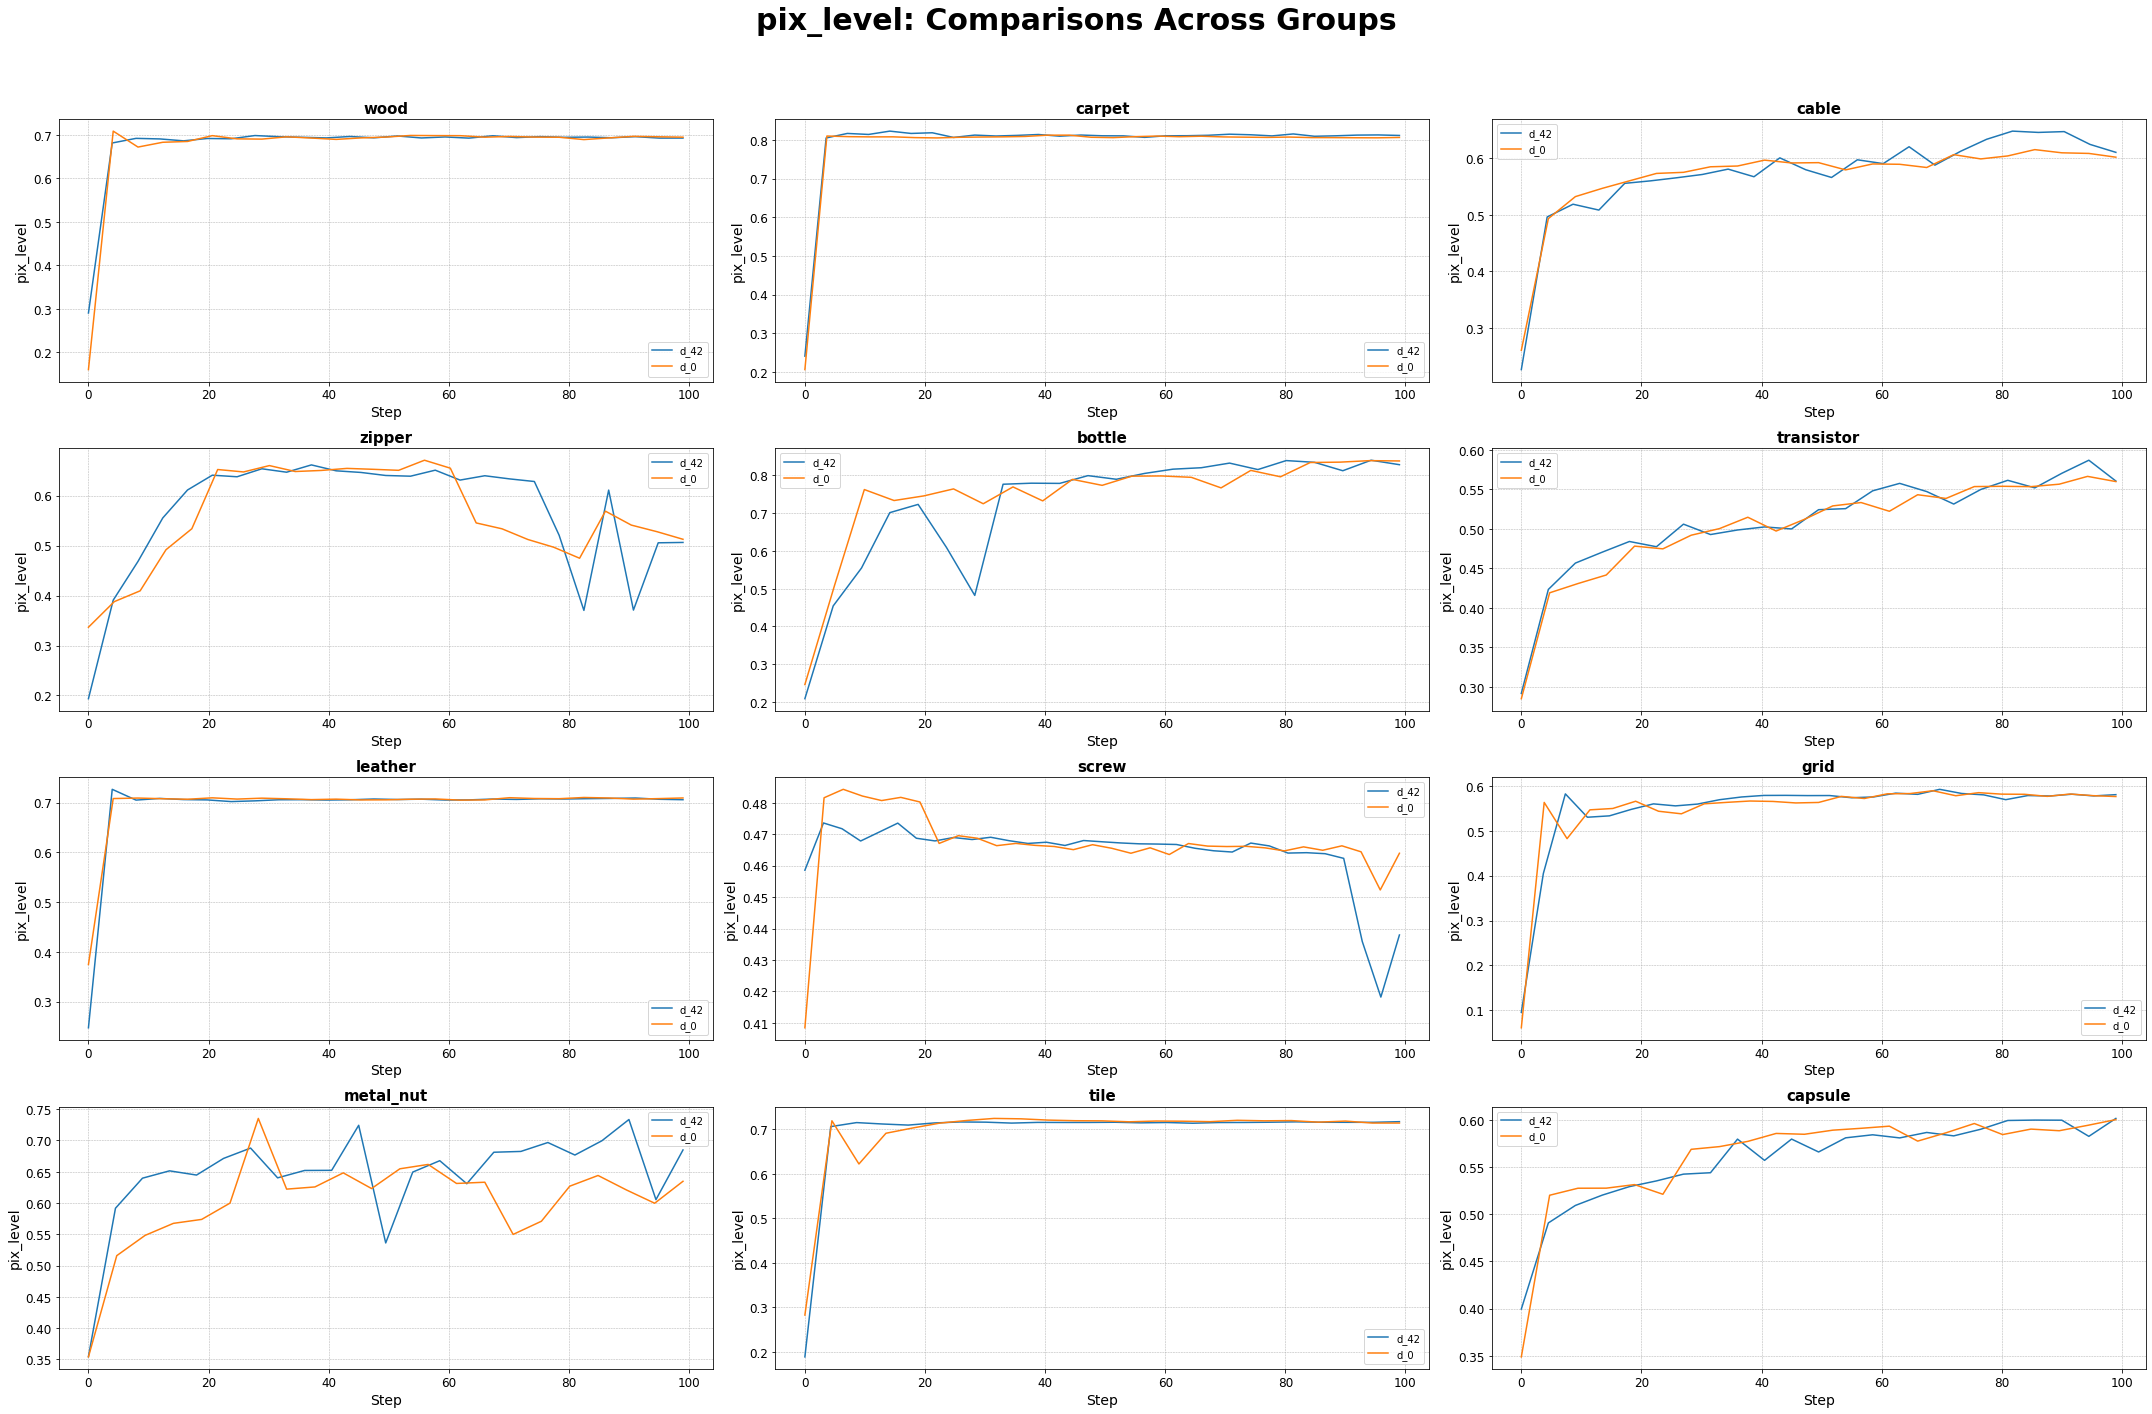

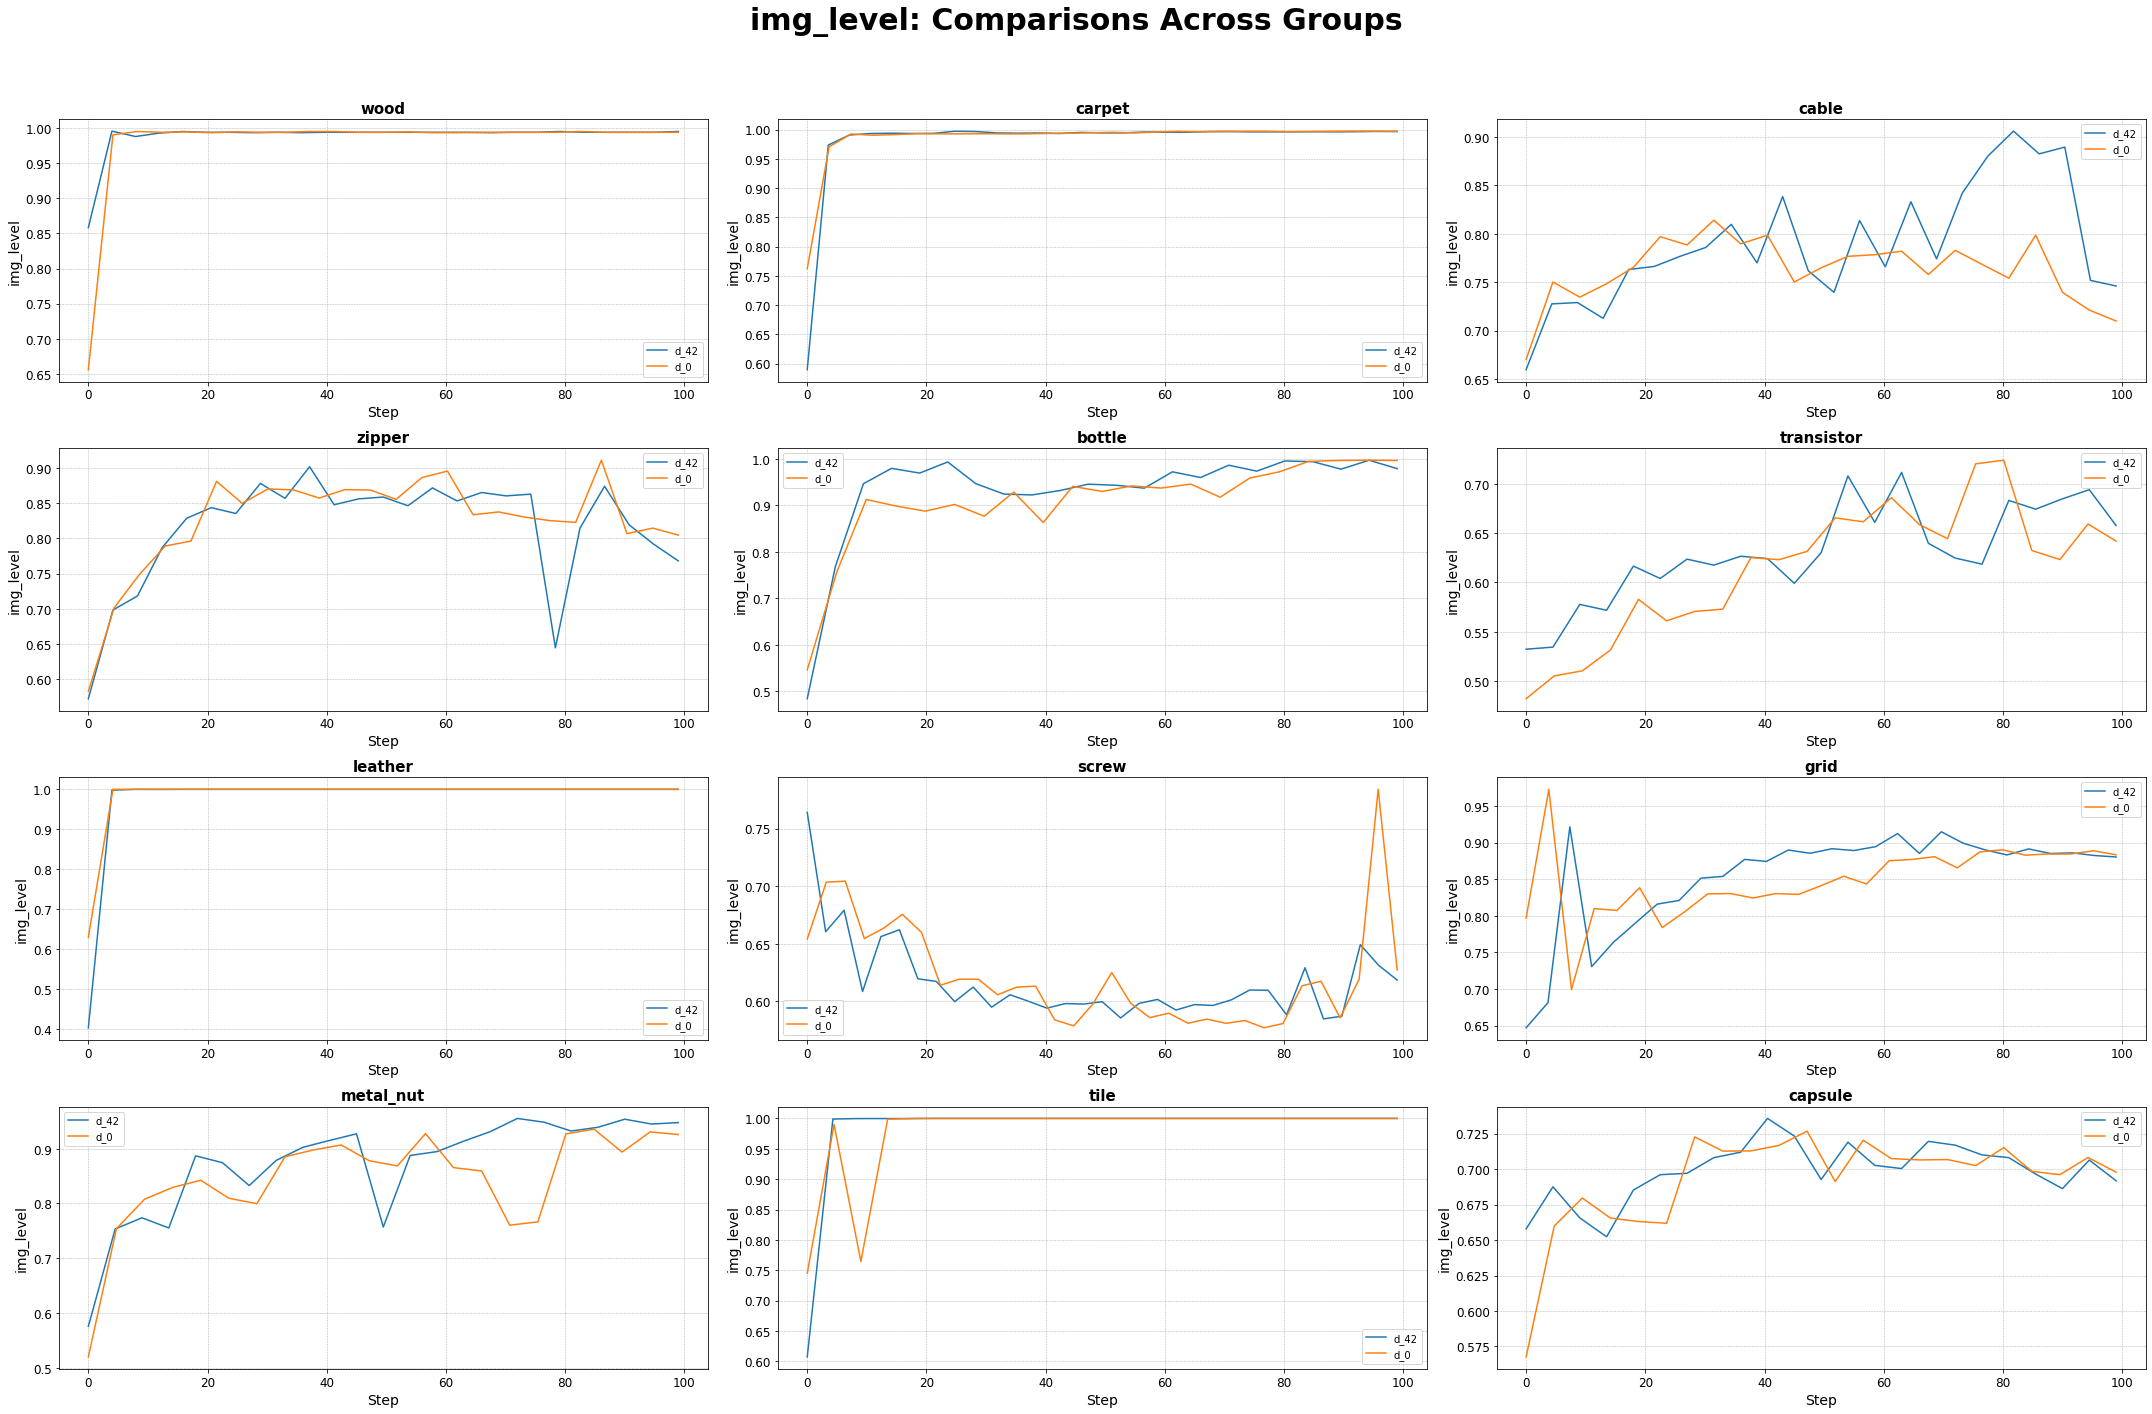

In [10]:
comparison_groups = results
excluded_classes = {'pill','toothbrush','hazelnut'}

for level in ['pix_level','img_level']:
    fig, axes = plt.subplots(4, 3, figsize=(30, 20))
    axes = axes.flatten()
    for i, class_name in enumerate(set(list(comparison_groups.values())[0]['class_name']) - excluded_classes):
        for group_name, group_data in comparison_groups.items():
            # Check if class_name exists in group_data
            if class_name in group_data['class_name'].values:
                group_filtered = preprocess(group_data[group_data['class_name'] == class_name])

                sns.lineplot(
                    x='epoch',
                    y=level,
                    data=group_filtered,
                    ax=axes[i],
                    label=group_name
                )

        axes[i].set_title(f"{class_name}", fontsize=15, fontweight='bold')
        axes[i].set_xlabel('Step', fontsize=14)
        axes[i].set_ylabel(f'{level}', fontsize=14)
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
        axes[i].tick_params(axis='both', which='major', labelsize=12)

    # Add an overarching title and adjust layout
    fig.suptitle(f'{level}: Comparisons Across Groups', fontsize=30, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    plt.show()


## Loss 

In [71]:
import re
def extract_loss(log_file_path):
    results = []
    # 정규 표현식 패턴 정의
    class_name_pattern = r"Current Class Name : (\w+)"
    loss_pattern = r"Total Loss: ([\d.]+)"
    step_pattern = r"\[([\d]+)/\d+\] Total Loss"  # Step 추출 (e.g., [10/264]에서 10을 추출)
    epoch_pattern = r"Train Epoch \[([\d]+)/\d+\]"

    # 파일 읽기 및 데이터 추출
    with open(log_file_path, "r") as log_file:
        current_class = None
        for line in log_file:
            # 현재 클래스 이름 추출
            class_match = re.search(class_name_pattern, line)
            if class_match:
                current_class = class_match.group(1)

            # 손실 값 및 스텝 추출
            step_match = re.search(step_pattern, line)
            loss_match = re.search(loss_pattern, line)
            epoch_match = re.search(epoch_pattern, line)
            if step_match and loss_match and current_class:
                step = int(step_match.group(1))  # 스텝은 정수로 변환
                loss = float(loss_match.group(1))  # 손실 값은 실수로 변환
                epoch = int(epoch_match.group(1))
                results.append({"class_name": current_class, "step": step, "loss": loss, 'epoch': epoch})

    # 결과 출력
    results = pd.DataFrame(results)
    return results 

loss_path = glob("/Volume/VAD/LifeLongerAD_pilot/results/ReverseDistillation/MVTecAD/*/seed_0/train.log")
results = {r.split('/')[-3].lstrip('baseline_EMPTY-'):extract_loss(r) for r in loss_path}

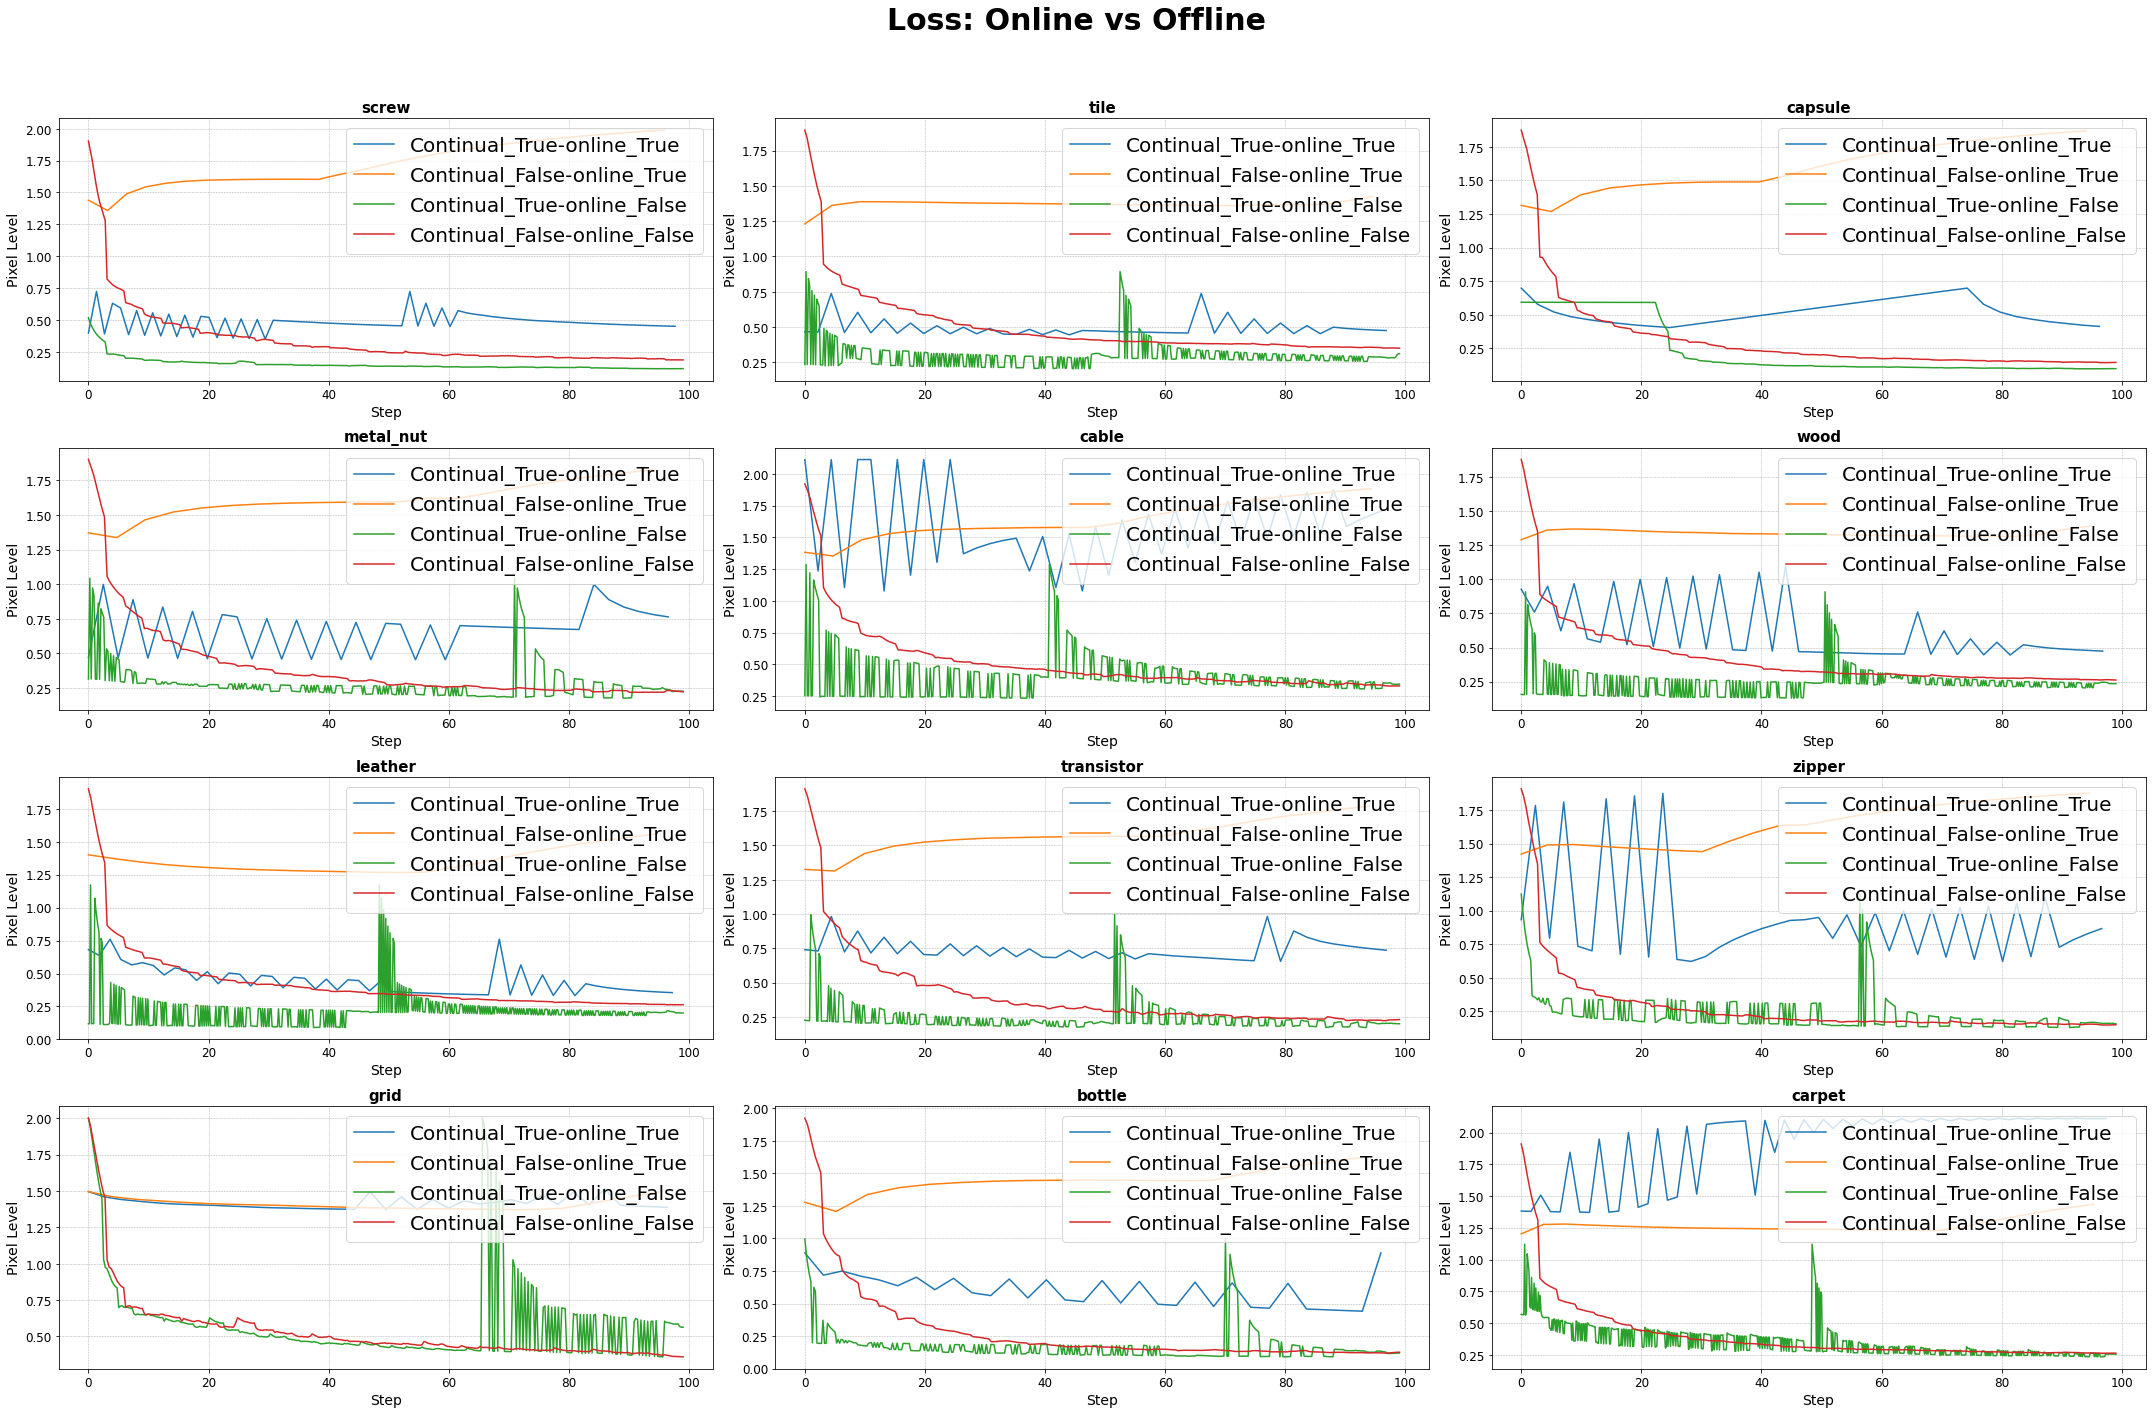

In [75]:
fig, axes = plt.subplots(4, 3, figsize=(30, 20))
axes = axes.flatten()

# Comparison groups dictionary
# Key: Group name, Value: DataFrame
comparison_groups = results

for i, class_name in enumerate(set(list(comparison_groups.values())[0]['class_name']) - excluded_classes):
    for group_name, group_data in comparison_groups.items():
        # Check if class_name exists in group_data
        if class_name in group_data['class_name'].values:
            if 'Online' in group_name :
                group_filtered = rescale_steps_with_filter(group_data[group_data['class_name'] == class_name], 'step')
                x_column = 'step'
            else:
                group_filtered = rescale_steps_with_filter(group_data[group_data['class_name'] == class_name].reset_index(), 'index')
                x_column = 'index'

            sns.lineplot(
                x=x_column,
                y='loss',
                data=group_filtered,
                ax=axes[i],
                label=group_name
            )

    axes[i].legend(fontsize=20, loc='upper right')
    axes[i].set_title(f"{class_name}", fontsize=15, fontweight='bold')
    axes[i].set_xlabel('Step', fontsize=14)
    axes[i].set_ylabel('Pixel Level', fontsize=14)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

# Add an overarching title and adjust layout
fig.suptitle('Loss: Online vs Offline', fontsize=30, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
plt.show()